In [1]:
from os.path import join, basename, splitext, dirname
from os import listdir
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
import cv2
from PIL import Image
import multiprocessing as mp
from shutil import copyfile
import random
from scipy.misc import imread
import pickle
import scipy

First we will get the set of video id's to pull the first frame from each and visualize it.

In [2]:
videoclips_path = '/home/zal/Data/VIRAT/Frames/imgs/'
videos = set()
for f in glob(join(videoclips_path, '*')):
    videos.add(basename(f)[:14])

videos = sorted(list(videos))

In [3]:
frames_paths = []
sample_fname = '1.jpg'
for video_name in videos:
    videoclips = sorted(list(glob(join(videoclips_path, video_name+'_*'))))
    if len(videoclips) == 0:
        frames_paths.append(join(videoclips_path, video_name, sample_fname))
    else:
        frames_paths.append(join(videoclips_path, videoclips[0], sample_fname))

print(len(frames_paths))
print('\n'.join(frames_paths))

72
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000000/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000001/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000002/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000003/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000004/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000005/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000006/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000007/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000008/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000101/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000102/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000200_00_000100_000171/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000201_00_000018_000380/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000202_00_000000_000977/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000203_00_000128_000160/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000204_00_000000_000109/1.jpg
/home/zal/Data/VIRAT/Frames/imgs/VIRAT_S_000205_

In [ ]:
plt.figure(figsize=(300,300))
columns = 5
for i, img_path in enumerate(frames_paths):
    img = mpimg.imread(img_path)
    ax = plt.subplot(len(frames_paths)//columns + 1, columns, i+1)
    ax.set_title(basename(dirname(img_path))[8:14])
    plt.axis('off')
    plt.imshow(img)

In [5]:
columns = 5
for i in range(0, len(frames_paths), columns):
    video_ids = map(lambda x: basename(dirname(x))[8:14], frames_paths[i:i+columns])
    print('        '.join(video_ids))

000000        000001        000002        000003        000004
000005        000006        000007        000008        000101
000102        000200        000201        000202        000203
000204        000205        000206        000207        010000
010001        010002        010003        010004        010005
010100        010101        010102        010103        010104
010105        010106        010107        010108        010109
010110        010111        010112        010113        010114
010115        010116        010200        010201        010202
010203        010204        010205        010206        010207
010208        040000        040001        040002        040003
040004        040005        040100        040101        040102
040103        040104        050000        050100        050101
050200        050201        050202        050203        050204
050300        050301


In [6]:
scene_ids_list = [['000000','000001','000002','000003','000004','000005','000006','000007','000008'],
['000101','000102'],
['000200','000201','000202','000203','000204','000205','000206','000207'],
['010000','010001','010002','010003','010004','010005'],
['010100','010101','010102','010103','010104','010105','010106','010107','010108','010109','010110','010111','010112','010113','010114','010115','010116'],
['010200','010201','010202','010203','010204','010205','010206','010207','010208'],
['040000','040001','040002','040003','040004','040005'],
['040100','040101','040102','040103','040104'],
['050000'],
['050100','050101'],
['050200','050201','050202','050203','050204'],
['050300','050301']]

In [7]:
seen_sid = [0, 2, 6, 7, 8]
unseen_sid = [1, 3, 4, 5, 9, 10, 11]

In [9]:
all_video_paths = sorted(glob(join(videoclips_path, '*')))
scenes_video_list = []
for ids_list in scene_ids_list:
    scenes_video_list.append(['VIRAT_S_'+video_id for video_id in ids_list])

scenes_path_list = []
for scene_videos in scenes_video_list:
    scene_paths = [p for p in all_video_paths if basename(p)[:14] in scene_videos]
    scenes_path_list.append(scene_paths)

In [10]:
scenes_file_list = []
for scene_path in scenes_path_list:
    scenes_file_list.append([item for p in scene_path for item in glob(join(p, '*.jpg'))])


1291995


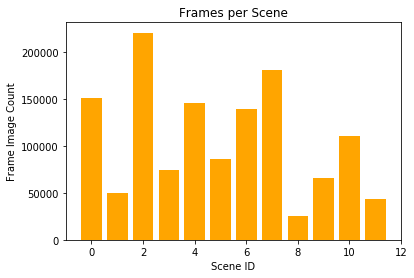

In [12]:
file_count_per_scene = []
for scene_files in scenes_file_list:
    file_count_per_scene.append(len(scene_files))

plt.bar(range(len(file_count_per_scene)), file_count_per_scene, color='orange')
plt.xlabel('Scene ID')
plt.ylabel('Frame Image Count')
plt.title('Frames per Scene')
print(sum(file_count_per_scene))

In [ ]:
def get_mean_img(img_path_list, img_id, sample_size=10000):
    w, h = Image.open(img_path_list[0]).size
    N = len(img_path_list)
    mean_img = np.zeros((h,w,3), np.float)
    
    for img_path in img_path_list:
        img = np.array(Image.open(img_path), dtype=np.float)
        mean_img = mean_img + img
    mean_img = np.divide(mean_img, N)
    mean_img = Image.fromarray(mean_img.astype(np.uint8))
    return mean_img, img_id

In [ ]:
mean_img = get_mean_img(scenes_file_list[8])
mean_img.show()

In [ ]:
mean_imgs = Parallel(n_jobs=mp.cpu_countcpu_count())(delayed(get_mean_img)(img_path_list, i) for i,img_path_list in escenes_file_listenes_file_list))

# Create smaller frames data

In [ ]:
frames_path = '/home/zal/Data/VIRAT/Frames/imgs/'
small_frames_path = '/home/zal/Data/VIRAT/Frames/small_imgs/'

all_frames_paths = glob(join(frames_path, '*/*.jpg'))
print(len(all_frames_paths))

In [ ]:
# Prepare the paths for files to be stored
for dir_path in glob(join(source_path, '*')):
    small_frames_dir = dir_path.replace(frames_path, small_frames_path)
    if not os.path.exists(small_frames_dir):
        os.makedirs(small_frames_dir)

In [ ]:
def smallify_frame(frame_path, source_path, target_path):
    try:
        img = Image.open(frame_path)
        img.thumbnail((480,480), Image.ANTIALIAS)
        img.save(frame_path.replace(source_path, target_path))
    except:
        print(frame_path)

In [ ]:
Parallel(n_jobs = mp.cpu_count())(delayed(smallify_frame)(frame_path=p, source_path=frames_path, target_path=small_frames_path) for p in all_frames_paths)

In [ ]:
all_small_frames_paths = glob(join(small_frames_path, '*/*.jpg'))
print(len(all_small_frames_paths))

# Extract all the first frames into a pool

### Test code

In [8]:
import pickle
import os.path as osp
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
viz_samples = pickle.load(open('/home/zal/Devel/Vehice_Action_Classifier/output/12.pkl', 'rb'))

/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_000003/18347.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_000101/14113.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_000202_01_001334_001520/1419.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_010000_00_000000_000165/1450.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_010108_01_000570_000718/125.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_010203_00_000047_000139/1685.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_040001_02_001102_001530/3136.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_040103_03_000284_000425/1354.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_050000_13_001722_001766/516.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_050100_11_001490_002015/7350.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_050201_01_000147_000321/4070.jpg
/home/zal/Data/VIRAT/Frames/small_imgs/VIRAT_S_050300_06_001427_001616/1560.jpg


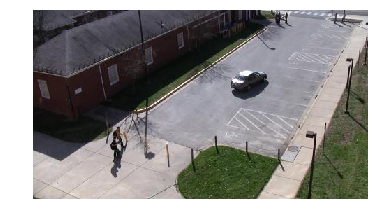

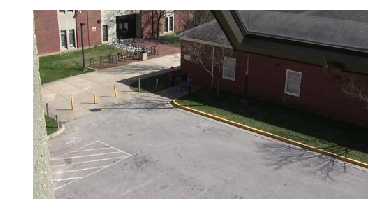

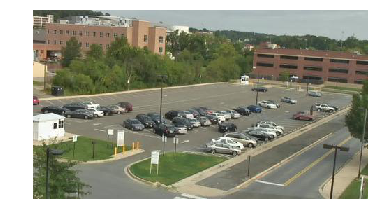

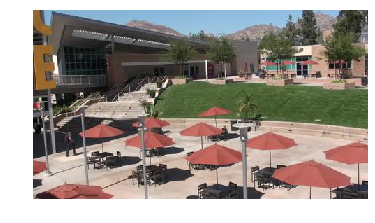

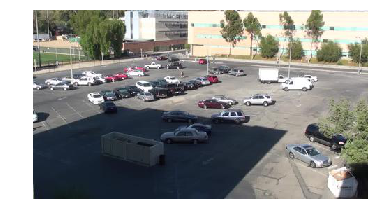

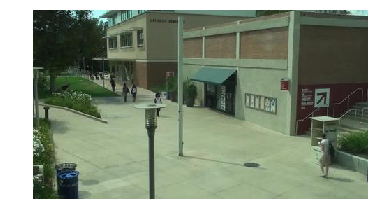

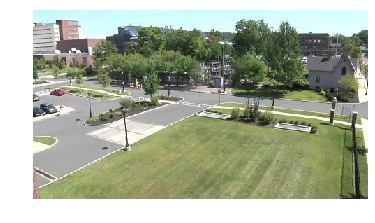

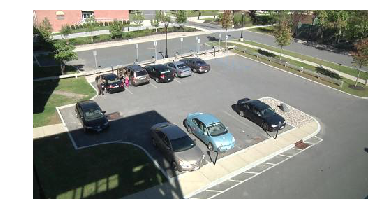

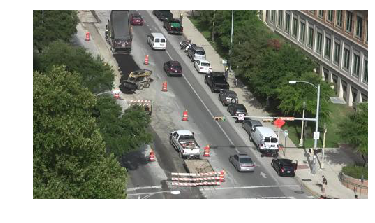

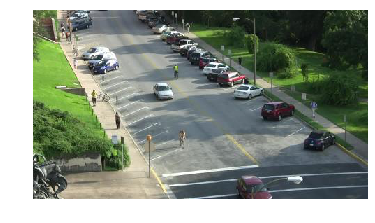

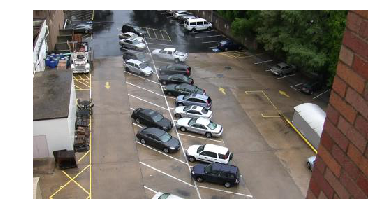

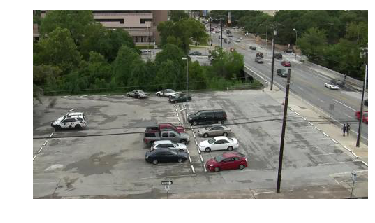

In [13]:
frames_dir = '/home/zal/Data/VIRAT/Frames/small_imgs'
for sid, s in enumerate(viz_samples):
    print(osp.join(frames_dir, s[0]))
    img = Image.open(osp.join(frames_dir, s[0]))
    img.save(osp.join('/home/zal/Devel/Vehice_Action_Classifier/output/', '%0d.jpg'%sid))
    plt.figure()
    plt.imshow(img)
    plt.axis('off')